In [1]:
import pandas as pd
import numpy as np
import random
import copy
import torch

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 42

In [3]:
data = pd.read_csv('../../GeneralData/ETTh2.csv')
data

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,41.130001,12.481,36.535999,9.355,4.424,1.311,38.661999
1,2016-07-01 01:00:00,37.528000,10.136,33.936001,7.532,4.435,1.215,37.124001
2,2016-07-01 02:00:00,37.946999,11.309,35.330002,9.007,2.100,0.000,36.465000
3,2016-07-01 03:00:00,38.952000,11.895,35.543999,9.436,3.380,1.215,33.608501
4,2016-07-01 04:00:00,38.113998,11.476,35.410000,9.623,2.036,0.000,31.850500
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,39.202999,11.392,49.644001,11.929,-10.331,-1.258,47.084999
17416,2018-06-26 16:00:00,38.113998,10.974,48.759998,11.366,-10.331,-1.290,48.183498
17417,2018-06-26 17:00:00,39.622002,10.974,50.609001,11.661,-11.557,-1.418,48.183498
17418,2018-06-26 18:00:00,43.643002,13.403,54.737000,13.778,-10.299,-1.418,46.865501


In [4]:
import torch.nn as nn

In [5]:
feature_size = 7

In [6]:
# LSTM은 Encoder와 Decoder를 각각 구현해야 한다.
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_size = 14
        self.input_size = feature_size
        self.encoder = nn.LSTM(input_size = self.input_size,
                       hidden_size = self.hidden_size,
                       num_layers = 1,
                       batch_first = True).to(device)
        # batch_first = True로 인해서 (batch,seq,feature)순으로 입력 받는다.
        # 그 당시에 알고 있는 정보가 없으므로 input_size = 0
        self.decoder = nn.LSTM(input_size = self.input_size,
                       hidden_size = self.hidden_size,
                       num_layers = 1,
                       batch_first = True).to(device)
        
        
        self.output_layer = nn.Linear(self.hidden_size, 1).to(device)
    def forward(self,x):
        x = x.to(device)
        self.encoder.flatten_parameters()
        self.decoder.flatten_parameters()
        outputs,(hidden,cell) = self.encoder(x)
        
        # 현재 prediction_length = 1이기 때문에, 반복문을 돌리지 않아도 됨
        # but 길어진다면 반복문을 돌려서 output값을 얻어야 한다.
        # 기본적으로 output = hidden state이기에 output을 생성할
        # Fully Connected Layer가 필요하게 된다.
        # 이때 decoder_output의 사이즈는 (batch,seq,hidden) 이다
        # 중간에 seq가 들어오게 되는 이유는 입력 크기 만큼 lstm이 반복되기 때문에
        # seq=1 이기 때문에 squeeze를 수행
        
        hidden = hidden.to(device)
        cell = cell.to(device)
        decoder_input = torch.zeros([x.size(0),1,x.size(2)]).to(device)
        decoder_out,(hidden,cell) = self.decoder(decoder_input,(hidden,cell))
        decoder_out = decoder_out.squeeze(1)
        
        out = self.output_layer(decoder_out)
        
        return out

In [7]:
a = np.array([1,2,3])
a.shape[0]

3

In [8]:
lst = [i for i in range(1,13)]
A = torch.FloatTensor(lst).view(3,2,2)
B = torch.zeros((2,2))
B[0,0] = 1
B[1,1] = 1
A*B # BroadCasting

tensor([[[ 1.,  0.],
         [ 0.,  4.]],

        [[ 5.,  0.],
         [ 0.,  8.]],

        [[ 9.,  0.],
         [ 0., 12.]]])

In [9]:
class Filter(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = LSTM()
    def forward(self,x,train_index_matrix=[]):
        # 2차원 인덱스 리스트가 들어온다.
        # train_index_matrix = 2차원
        # 행은 time 열은 Feature를 의미
        if len(train_index_matrix)==0:
            return self.model(x)
        filters = torch.FloatTensor(np.full((x.shape[1],x.shape[2]),-np.inf))
        filters = filters.to(device)
        for i in range(len(train_index_matrix)):
            for train_idx in train_index_matrix[i]:
                filters[train_idx,i] = 1
        x = x*filters
        out = self.model(x)
        return out

In [10]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch

In [11]:
device = torch.device("cuda:0")

In [12]:
sequence_length = 168 # 24*7 1주일
pred_length = 1 # 1시간
split = int(len(data)*0.8)

In [13]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(0,len(x)-sequence_length):
        # 시간데이터를 제외하고 추출
        seq_list.append(x.iloc[i:i+sequence_length,1:].values)
        # OT만 추출
        target_list.append(x.iloc[i+sequence_length,-1])
        
    return torch.FloatTensor(seq_list).view(-1,sequence_length,7).to(device), torch.FloatTensor(target_list).view(-1,pred_len,1).to(device)

In [14]:
train = data.iloc[:split]
val = data.iloc[split:]

X_train, y_train = seq_data(train,sequence_length,pred_length)
X_val, y_val = seq_data(val,sequence_length,pred_length)

tr_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val,y_val)

training =  DataLoader(tr_dataset,batch_size = 64)
validation = DataLoader(val_dataset,batch_size = 64)

/tmp/ipykernel_1369049/2507691695.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return torch.FloatTensor(seq_list).view(-1,sequence_length,7).to(device), torch.FloatTensor(target_list).view(-1,pred_len,1).to(device)


In [15]:
torch.cuda.is_available()

True

In [16]:
X_train.size() # 168개의 sequence_length 7개의 Feature

torch.Size([13768, 168, 7])

* 잘 데이터가 구성된 걸 확인 가능

In [17]:
train.iloc[:169]

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,41.130001,12.481,36.535999,9.355,4.424,1.311,38.661999
1,2016-07-01 01:00:00,37.528000,10.136,33.936001,7.532,4.435,1.215,37.124001
2,2016-07-01 02:00:00,37.946999,11.309,35.330002,9.007,2.100,0.000,36.465000
3,2016-07-01 03:00:00,38.952000,11.895,35.543999,9.436,3.380,1.215,33.608501
4,2016-07-01 04:00:00,38.113998,11.476,35.410000,9.623,2.036,0.000,31.850500
...,...,...,...,...,...,...,...,...
164,2016-07-07 20:00:00,46.155998,12.900,42.112000,10.079,3.497,0.000,41.299000
165,2016-07-07 21:00:00,50.008999,14.659,45.865002,11.205,3.753,1.237,40.200500
166,2016-07-07 22:00:00,46.826000,14.743,44.417000,12.223,2.580,0.000,39.321499
167,2016-07-07 23:00:00,45.235001,13.905,43.022999,11.714,2.665,0.000,38.881500


In [18]:
X_train

tensor([[[41.1300, 12.4810, 36.5360,  ...,  4.4240,  1.3110, 38.6620],
         [37.5280, 10.1360, 33.9360,  ...,  4.4350,  1.2150, 37.1240],
         [37.9470, 11.3090, 35.3300,  ...,  2.1000,  0.0000, 36.4650],
         ...,
         [50.0090, 14.6590, 45.8650,  ...,  3.7530,  1.2370, 40.2005],
         [46.8260, 14.7430, 44.4170,  ...,  2.5800,  0.0000, 39.3215],
         [45.2350, 13.9050, 43.0230,  ...,  2.6650,  0.0000, 38.8815]],

        [[37.5280, 10.1360, 33.9360,  ...,  4.4350,  1.2150, 37.1240],
         [37.9470, 11.3090, 35.3300,  ...,  2.1000,  0.0000, 36.4650],
         [38.9520, 11.8950, 35.5440,  ...,  3.3800,  1.2150, 33.6085],
         ...,
         [46.8260, 14.7430, 44.4170,  ...,  2.5800,  0.0000, 39.3215],
         [45.2350, 13.9050, 43.0230,  ...,  2.6650,  0.0000, 38.8815],
         [44.7320, 13.9050, 42.4340,  ...,  1.3110,  0.0000, 38.2230]],

        [[37.9470, 11.3090, 35.3300,  ...,  2.1000,  0.0000, 36.4650],
         [38.9520, 11.8950, 35.5440,  ...,  3

In [19]:
y_train

tensor([[[38.2230]],

        [[38.0030]],

        [[37.5635]],

        ...,

        [[15.5910]],

        [[15.8105]],

        [[15.1515]]], device='cuda:0')

In [20]:
from torch.optim import Adam

In [21]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
model = Filter().to(device)
optimizer = Adam(model.parameters(),lr = 1e-4)
num_epochs = 200
n = len(training)

In [22]:
def MSE(pred,target):
    return torch.mean((pred-target)**2,dim = 0) # reduction까지 취해줌

In [23]:
model.named_parameters

<bound method Module.named_parameters of Filter(
  (model): LSTM(
    (encoder): LSTM(7, 14, batch_first=True)
    (decoder): LSTM(7, 14, batch_first=True)
    (output_layer): Linear(in_features=14, out_features=1, bias=True)
  )
)>

In [24]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
minimal_loss=np.inf
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
#         print(outputs.size())
        outputs = outputs.view(-1,1)    
        labels = labels.view(-1,1)
        
        # defining loss
        loss = MSE(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)))
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model

Epoch [1]/[200] running accumulative loss across all batches: 869.021
changed
Epoch [2]/[200] running accumulative loss across all batches: 859.793
changed
Epoch [3]/[200] running accumulative loss across all batches: 846.626
changed
Epoch [4]/[200] running accumulative loss across all batches: 829.433
changed
Epoch [5]/[200] running accumulative loss across all batches: 809.352
changed
Epoch [6]/[200] running accumulative loss across all batches: 783.139
changed
Epoch [7]/[200] running accumulative loss across all batches: 761.134
changed
Epoch [8]/[200] running accumulative loss across all batches: 740.211
changed
Epoch [9]/[200] running accumulative loss across all batches: 720.916
changed
Epoch [10]/[200] running accumulative loss across all batches: 704.162
changed
Epoch [11]/[200] running accumulative loss across all batches: 688.206
changed
Epoch [12]/[200] running accumulative loss across all batches: 671.672
changed
Epoch [13]/[200] running accumulative loss across all batches

Epoch [105]/[200] running accumulative loss across all batches: 91.972
changed
Epoch [106]/[200] running accumulative loss across all batches: 89.842
changed
Epoch [107]/[200] running accumulative loss across all batches: 87.755
changed
Epoch [108]/[200] running accumulative loss across all batches: 85.712
changed
Epoch [109]/[200] running accumulative loss across all batches: 83.709
changed
Epoch [110]/[200] running accumulative loss across all batches: 81.746
changed
Epoch [111]/[200] running accumulative loss across all batches: 79.820
changed
Epoch [112]/[200] running accumulative loss across all batches: 77.936
changed
Epoch [113]/[200] running accumulative loss across all batches: 76.092
changed
Epoch [114]/[200] running accumulative loss across all batches: 74.291
changed
Epoch [115]/[200] running accumulative loss across all batches: 72.519
changed
Epoch [116]/[200] running accumulative loss across all batches: 70.785
changed
Epoch [117]/[200] running accumulative loss across a

In [25]:
from captum.attr import IntegratedGradients,NoiseTunnel

In [26]:
for val in validation:
    print(val[0].size())

torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])


In [27]:
test = next(iter(validation))[0][0] # 하나의 sample에 대해서 진행
test = test.unsqueeze(0)
test.size()

torch.Size([1, 168, 7])

In [28]:
ig = IntegratedGradients(model)
attr_score = ig.attribute(test,return_convergence_delta=True)
attr_score

(tensor([[[-5.9376e-07, -3.7675e-07,  8.0071e-06,  ...,  1.2761e-07,
            9.6813e-08,  1.6448e-07],
          [-7.4945e-06,  0.0000e+00, -1.1281e-05,  ...,  1.1797e-06,
            1.0376e-07,  6.3016e-06],
          [-4.2601e-06,  0.0000e+00, -1.8901e-05,  ...,  1.2249e-06,
            3.4152e-07,  5.9723e-06],
          ...,
          [ 1.5233e+00, -1.6451e-01,  1.4713e-01,  ...,  6.5818e-01,
            3.0750e-01, -4.4704e+00],
          [-3.8615e-01,  1.4236e+00,  1.8733e+00,  ..., -9.9529e-01,
           -2.7344e-01, -2.3982e+00],
          [-5.6711e+00,  3.6636e-02,  5.2496e-01,  ..., -1.1558e+00,
           -6.3748e-01,  2.6021e+01]]], device='cuda:0', dtype=torch.float64),
 tensor([-3.9857e-06], device='cuda:0', dtype=torch.float64))

In [29]:
attr_score[0].size()

torch.Size([1, 168, 7])

In [30]:
delta = attr_score[1]

In [31]:
attr_score = attr_score[0]

In [32]:
attr_score.to("cpu")

tensor([[[-5.9376e-07, -3.7675e-07,  8.0071e-06,  ...,  1.2761e-07,
           9.6813e-08,  1.6448e-07],
         [-7.4945e-06,  0.0000e+00, -1.1281e-05,  ...,  1.1797e-06,
           1.0376e-07,  6.3016e-06],
         [-4.2601e-06,  0.0000e+00, -1.8901e-05,  ...,  1.2249e-06,
           3.4152e-07,  5.9723e-06],
         ...,
         [ 1.5233e+00, -1.6451e-01,  1.4713e-01,  ...,  6.5818e-01,
           3.0750e-01, -4.4704e+00],
         [-3.8615e-01,  1.4236e+00,  1.8733e+00,  ..., -9.9529e-01,
          -2.7344e-01, -2.3982e+00],
         [-5.6711e+00,  3.6636e-02,  5.2496e-01,  ..., -1.1558e+00,
          -6.3748e-01,  2.6021e+01]]], dtype=torch.float64)

In [33]:
plot_attribution = attr_score.to("cpu").detach().numpy()
plot_attribution

array([[[-5.93761354e-07, -3.76745438e-07,  8.00714640e-06, ...,
          1.27606839e-07,  9.68127471e-08,  1.64477127e-07],
        [-7.49452183e-06,  0.00000000e+00, -1.12811741e-05, ...,
          1.17965311e-06,  1.03760385e-07,  6.30161868e-06],
        [-4.26008245e-06,  0.00000000e+00, -1.89006913e-05, ...,
          1.22486993e-06,  3.41517109e-07,  5.97233259e-06],
        ...,
        [ 1.52325544e+00, -1.64511184e-01,  1.47128679e-01, ...,
          6.58180277e-01,  3.07498897e-01, -4.47035561e+00],
        [-3.86150722e-01,  1.42360606e+00,  1.87333183e+00, ...,
         -9.95289292e-01, -2.73444132e-01, -2.39815310e+00],
        [-5.67106171e+00,  3.66356746e-02,  5.24960906e-01, ...,
         -1.15581566e+00, -6.37483571e-01,  2.60209572e+01]]])

In [34]:
plot_attribution = plot_attribution.reshape(-1,7)

In [35]:
column = data.columns[1:]
column

Index(['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')

In [36]:
attr_df = pd.DataFrame(plot_attribution,columns=column)

In [37]:
attr_df

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,-5.937614e-07,-3.767454e-07,0.000008,-4.720117e-07,1.276068e-07,9.681275e-08,1.644771e-07
1,-7.494522e-06,0.000000e+00,-0.000011,-2.548996e-07,1.179653e-06,1.037604e-07,6.301619e-06
2,-4.260082e-06,0.000000e+00,-0.000019,-4.238541e-07,1.224870e-06,3.415171e-07,5.972333e-06
3,-1.352139e-06,0.000000e+00,-0.000017,-6.349034e-07,1.292195e-06,4.391364e-07,3.521359e-06
4,6.639321e-07,0.000000e+00,-0.000011,-9.172286e-07,5.994110e-07,-0.000000e+00,2.196285e-06
...,...,...,...,...,...,...,...
163,7.698017e-02,-9.615090e-03,0.616925,-9.428118e-02,1.119212e-01,-2.352201e-02,3.458251e-01
164,3.991378e-01,-3.675092e-01,0.395621,-2.010101e-01,3.596672e-01,6.845013e-02,4.057561e-01
165,1.523255e+00,-1.645112e-01,0.147129,3.332237e-01,6.581803e-01,3.074989e-01,-4.470356e+00
166,-3.861507e-01,1.423606e+00,1.873332,3.373219e-01,-9.952893e-01,-2.734441e-01,-2.398153e+00


# 특징 관찰

### our goal -> 특정 시간대를 추출해내는 방법을 고안

In [38]:
next(iter(validation))[1][0]

tensor([[18.0080]], device='cuda:0')

* 전체 Attribution DataFrame이 예측값을 나눈것으로 보임
    * 현재 하나의 Sample Batch의 첫번째 Sample에 대해서 Attribution을 구했는데
    하나의 DataFrame이 나왔음

In [39]:
attr_df.sum(axis=0).sum()

20.353023358000325

1. delta가 attribution 유의미하게 작은지 확인
2. baseline vector 넣었을떄 0인지

### 1의 답

In [40]:
delta

tensor([-3.9857e-06], device='cuda:0', dtype=torch.float64)

In [41]:
test_baseline = torch.FloatTensor(np.zeros((1,sequence_length,7)))
base_pred = model(test_baseline)
base_pred

tensor([[-1.1632]], device='cuda:0', grad_fn=<AddmmBackward0>)

### 2의 답

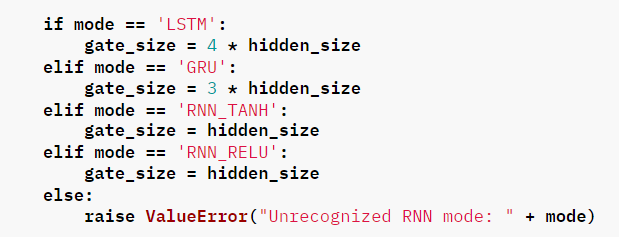
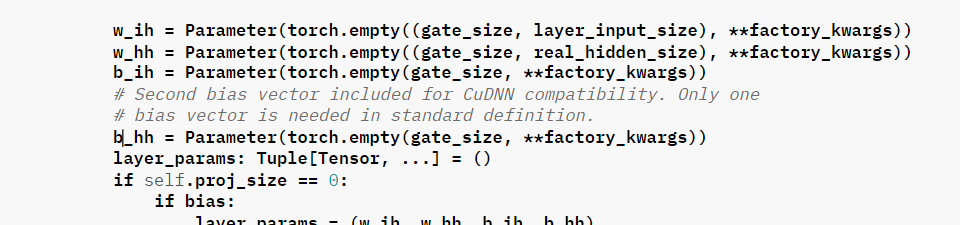

<font color = blue><font size = 5> what is CuDNN Compatibility?</font></font>

https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html

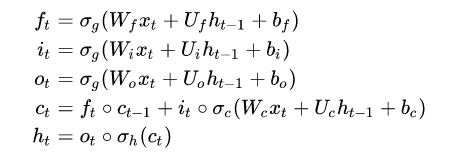

* **LSTM의 bias는 4개가 존재하고 따라서 4*hiddensize만큼의 bias element갯수가 존재한다.**

In [42]:
bias1 = model.model.encoder.bias_hh_l0
bias1

Parameter containing:
tensor([ 1.2425e-01,  1.7119e-01,  1.4981e-01, -3.0981e-02, -9.8803e-02,
         3.3065e-04, -4.4783e-02,  3.0091e-01, -2.4299e-01, -6.0651e-02,
         5.2567e-02, -1.8909e-01,  2.0321e-01,  1.5763e-02, -2.0488e-01,
         1.5315e-01,  1.2949e-03,  6.1289e-02,  4.9839e-02, -2.1649e-01,
        -7.1373e-02,  1.6620e-01, -1.5907e-01,  1.6151e-01,  7.3871e-02,
         9.6761e-02,  1.5812e-01, -3.0812e-01, -1.7868e-01,  1.5573e-01,
        -1.8798e-01, -1.1819e-01,  3.6475e-01,  2.0230e-01, -2.0360e-01,
         6.5346e-02, -3.5945e-02, -3.9119e-01, -4.7118e-02,  3.0285e-01,
        -1.6907e-01,  2.1432e-01, -2.1799e-02,  3.3050e-02,  8.0844e-02,
         3.0982e-01, -3.4484e-02, -2.2945e-02, -3.8639e-02,  3.9797e-02,
        -7.2267e-02,  8.0096e-02, -5.4109e-01,  2.6342e-01,  3.2703e-01,
        -2.7348e-02], device='cuda:0', requires_grad=True)

In [43]:
bias1.sum(axis=0)

tensor(0.6618, device='cuda:0', grad_fn=<SumBackward1>)

In [44]:
model.model.encoder.bias_hh_l0.size()

torch.Size([56])

In [45]:
bias2 = model.model.encoder.bias_ih_l0
bias2

Parameter containing:
tensor([ 2.0111e-01,  1.9032e-01,  1.5324e-01,  7.1564e-02, -1.7432e-02,
        -1.7550e-02, -3.0698e-01, -1.2989e-01, -6.9852e-02, -1.5548e-01,
        -2.2704e-03, -1.7943e-01,  6.2616e-02,  1.6042e-01, -4.6507e-02,
         3.9614e-01,  3.3352e-01, -1.6980e-01, -1.2549e-01, -1.6762e-01,
        -1.6914e-01,  8.7762e-02, -1.0038e-01, -1.4904e-01, -2.8438e-03,
        -1.5984e-01, -4.7602e-03,  1.7968e-01, -3.4054e-01, -2.5712e-01,
         9.7936e-02,  3.9124e-02,  3.0775e-01,  1.5455e-01,  1.9105e-01,
        -2.9120e-01,  1.7006e-01,  9.6616e-02, -1.9918e-01,  4.6217e-01,
         1.1146e-01,  1.2427e-01,  3.3559e-01, -2.4561e-01, -3.8011e-01,
         2.3000e-01, -1.0511e-04, -2.8564e-01,  2.8435e-01, -1.2172e-01,
         1.8326e-01,  4.8763e-01, -2.7092e-01, -8.4024e-02,  2.7573e-01,
         2.6092e-01], device='cuda:0', requires_grad=True)

In [46]:
bias2.sum(axis = 0)

tensor(1.1983, device='cuda:0', grad_fn=<SumBackward1>)

* 하나의 샘플은 모두 (168,7)의 동일한 크기를 갖는다.

In [47]:
cnt = 0
ig = IntegratedGradients(model)
ig_attr_score = np.zeros((sequence_length,feature_size))
for val_batch in validation:
    temp_n = val_batch[0].size(0)
    for val in val_batch[0]: # 하나의 배치에 대해서 for문
        val = val.unsqueeze(0)
        temp = ig.attribute(val).abs()
        # 각 attribution score의 절대값을 합한다.
        # 이로써 각 시간별로 영향도를 구함
        # 이 부분이 abs를 씌우는게 절대적인 영향을 반영하는데에 맞는 것 같다.
        # 이전까진 씌우지 않았음
        temp = temp.squeeze(0)
        temp = temp.to("cpu").detach().numpy()   
        ig_attr_score = ig_attr_score+temp
    cnt = cnt + temp_n
ig_attr_score = ig_attr_score/cnt

In [48]:
data.columns[1:]

Index(['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')

In [49]:
ig_attr_score[:,0]

array([2.59856345e-05, 1.65490564e-05, 1.72952217e-05, 1.87023958e-05,
       1.94142445e-05, 2.01590827e-05, 2.08769183e-05, 2.15473323e-05,
       2.22396215e-05, 2.30522405e-05, 2.38752708e-05, 2.47624382e-05,
       2.56773020e-05, 2.67186627e-05, 2.78485390e-05, 2.89876680e-05,
       3.01967823e-05, 3.13748079e-05, 3.26185486e-05, 3.39375554e-05,
       3.53695975e-05, 3.68214059e-05, 3.83135698e-05, 3.98833560e-05,
       4.13093601e-05, 4.24050002e-05, 4.32409367e-05, 4.39491717e-05,
       4.45828156e-05, 4.52628410e-05, 4.60041313e-05, 4.67455497e-05,
       4.76274796e-05, 4.87324065e-05, 5.01010051e-05, 5.16983260e-05,
       5.36617373e-05, 5.59341331e-05, 5.84096126e-05, 6.09557144e-05,
       6.35484185e-05, 6.62135253e-05, 6.89774132e-05, 7.23263077e-05,
       7.56442621e-05, 7.88339637e-05, 8.18668055e-05, 8.43979751e-05,
       8.62795323e-05, 8.75582581e-05, 8.85992993e-05, 8.95315477e-05,
       9.03006480e-05, 9.11518917e-05, 9.22296873e-05, 9.39853423e-05,
      

In [50]:
np

<module 'numpy' from '/home/sjlee/sj_virtual/lib/python3.8/site-packages/numpy/__init__.py'>

In [51]:
sub_attr_df = []
for cnt,column in enumerate(list(data.columns[1:])):
    attr_df = pd.DataFrame(ig_attr_score[:,0],columns = [column])
    sub_attr_df.append(attr_df)
sub_attr_df

[         HUFL
 0    0.000026
 1    0.000017
 2    0.000017
 3    0.000019
 4    0.000019
 ..        ...
 163  0.096614
 164  0.308161
 165  0.959245
 166  1.954634
 167  8.199329
 
 [168 rows x 1 columns],
          HULL
 0    0.000026
 1    0.000017
 2    0.000017
 3    0.000019
 4    0.000019
 ..        ...
 163  0.096614
 164  0.308161
 165  0.959245
 166  1.954634
 167  8.199329
 
 [168 rows x 1 columns],
          MUFL
 0    0.000026
 1    0.000017
 2    0.000017
 3    0.000019
 4    0.000019
 ..        ...
 163  0.096614
 164  0.308161
 165  0.959245
 166  1.954634
 167  8.199329
 
 [168 rows x 1 columns],
          MULL
 0    0.000026
 1    0.000017
 2    0.000017
 3    0.000019
 4    0.000019
 ..        ...
 163  0.096614
 164  0.308161
 165  0.959245
 166  1.954634
 167  8.199329
 
 [168 rows x 1 columns],
          LUFL
 0    0.000026
 1    0.000017
 2    0.000017
 3    0.000019
 4    0.000019
 ..        ...
 163  0.096614
 164  0.308161
 165  0.959245
 166  1.954634
 167  8

In [52]:
candidate_sub_attr_df = []
for attr_df in sub_attr_df:
    IQR = 1.5*(attr_df.quantile(0.75)-attr_df.quantile(0.25))
    outlier_max = attr_df.quantile(0.75)+IQR
    outlier_min = attr_df.quantile(0.25)-IQR
    candidate_attr = attr_df[(attr_df>=outlier_min) & (attr_df<=outlier_max)]
    candidate_attr = candidate_attr.dropna()
    candidate_sub_attr_df.append(candidate_attr)
candidate_sub_attr_df

[         HUFL
 0    0.000026
 1    0.000017
 2    0.000017
 3    0.000019
 4    0.000019
 ..        ...
 135  0.002707
 136  0.002906
 137  0.003110
 138  0.003341
 139  0.003609
 
 [140 rows x 1 columns],
          HULL
 0    0.000026
 1    0.000017
 2    0.000017
 3    0.000019
 4    0.000019
 ..        ...
 135  0.002707
 136  0.002906
 137  0.003110
 138  0.003341
 139  0.003609
 
 [140 rows x 1 columns],
          MUFL
 0    0.000026
 1    0.000017
 2    0.000017
 3    0.000019
 4    0.000019
 ..        ...
 135  0.002707
 136  0.002906
 137  0.003110
 138  0.003341
 139  0.003609
 
 [140 rows x 1 columns],
          MULL
 0    0.000026
 1    0.000017
 2    0.000017
 3    0.000019
 4    0.000019
 ..        ...
 135  0.002707
 136  0.002906
 137  0.003110
 138  0.003341
 139  0.003609
 
 [140 rows x 1 columns],
          LUFL
 0    0.000026
 1    0.000017
 2    0.000017
 3    0.000019
 4    0.000019
 ..        ...
 135  0.002707
 136  0.002906
 137  0.003110
 138  0.003341
 139  0

In [53]:
import matplotlib.pyplot as plt

[         attr
 0    0.002627
 1    0.000000
 2    0.000208
 3    0.000599
 4    0.000798
 ..        ...
 135  0.749033
 136  0.804274
 137  0.861188
 138  0.925440
 139  1.000000
 
 [140 rows x 1 columns],
          attr
 0    0.002627
 1    0.000000
 2    0.000208
 3    0.000599
 4    0.000798
 ..        ...
 135  0.749033
 136  0.804274
 137  0.861188
 138  0.925440
 139  1.000000
 
 [140 rows x 1 columns],
          attr
 0    0.002627
 1    0.000000
 2    0.000208
 3    0.000599
 4    0.000798
 ..        ...
 135  0.749033
 136  0.804274
 137  0.861188
 138  0.925440
 139  1.000000
 
 [140 rows x 1 columns],
          attr
 0    0.002627
 1    0.000000
 2    0.000208
 3    0.000599
 4    0.000798
 ..        ...
 135  0.749033
 136  0.804274
 137  0.861188
 138  0.925440
 139  1.000000
 
 [140 rows x 1 columns],
          attr
 0    0.002627
 1    0.000000
 2    0.000208
 3    0.000599
 4    0.000798
 ..        ...
 135  0.749033
 136  0.804274
 137  0.861188
 138  0.925440
 139  1

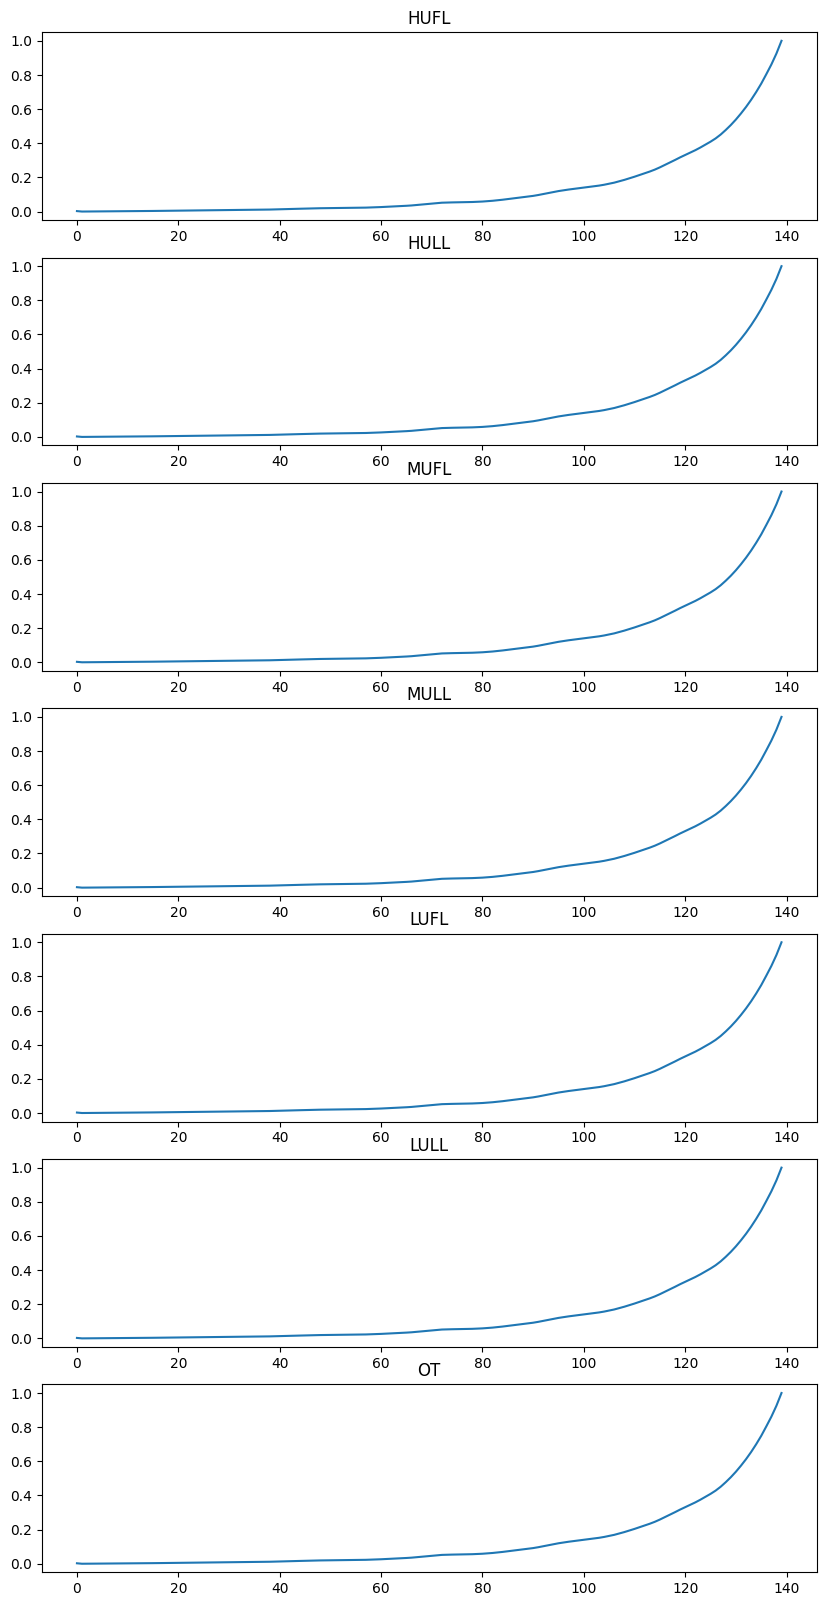

In [54]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
filtering_attr_list = [] # scaling한 attribution dataframe을 저장
fig,ax = plt.subplots(7,1,figsize = (10,20))
for cnt,candidate_attr in enumerate(candidate_sub_attr_df):
    scaler = MinMaxScaler()
    scaler.fit(candidate_attr.values)
    m_attr_df = scaler.transform(candidate_attr.values)
    m_attr_df = pd.DataFrame({"attr":m_attr_df.reshape(-1)})
    filtering_attr_list.append(m_attr_df)
    ax[cnt].plot(m_attr_df)
    ax[cnt].set_title(candidate_attr.columns.item())
filtering_attr_list

In [55]:
total_index_list = [] # train할 index를 저장해두는 리스트이다.
for hyper_para in np.arange(0.00,1.00,0.01):
    index_list = []
    # filtering index를 만든다.
    for m_attr_df in filtering_attr_list:
        append_idx = list(m_attr_df[(m_attr_df['attr']>=hyper_para)].index)
        index_list.append(append_idx)
    total_index_list.append(index_list)
len(total_index_list) 

100

In [56]:
from pytorch_forecasting.metrics import SMAPE,MAE,RMSE

In [ ]:
### 원래 난수가 선언된 위치
m = len(validation)
n = len(training)
cnt = 0
num_epochs = 100
mse_out_list = []
mae_out_list = []
smape_out_list = []
rmse_out_list = []
for sub_index_list in total_index_list: #0.01~1.00 100개의 index에 대해서 수행
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
    train_idx = sub_index_list
    minimal_loss=np.inf
    model = Filter().to(device) # 모델 초기화
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
    result = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in training:
            # forward pass
            inputs = inputs
            
            outputs = model(inputs,train_idx)
            outputs = outputs.view(-1,1)
            labels = labels.view(-1,1)            
            # defining loss
            loss = MSE(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch == 99:    
            print(f'{cnt}번째 모델 Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
        
        if (running_loss/n)*100<minimal_loss:
            best_model = copy.deepcopy(model)
            minimal_loss = (running_loss/n)*100
            print("changed")

    model = best_model
    cnt+=1
    # 모델 Fully-Training 완료
    
    pred = torch.FloatTensor().to(device)
    val_target = torch.FloatTensor().to(device)
    for val_x,val_y in validation:
        tmp_pred = model(val_x)
        pred = torch.concat([pred,tmp_pred], dim=0)
        val_target = torch.concat([val_target,val_y],dim = 0)
    pred = pred.view(-1,1)
    val_target = val_target.view(-1,1)
    result = MSE(pred,val_target).item()
    mse_out_list.append(result)
    mae_out_list.append(MAE()(pred,val_target).item())
    rmse_out_list.append(RMSE()(pred,val_target).item())
    smape_out_list.append(SMAPE()(pred,val_target).item()*100)

In [63]:
len(mse_out_list)

100

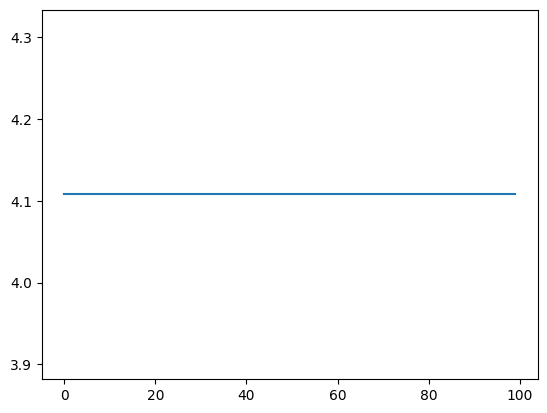

In [64]:
plt.plot(mse_out_list)

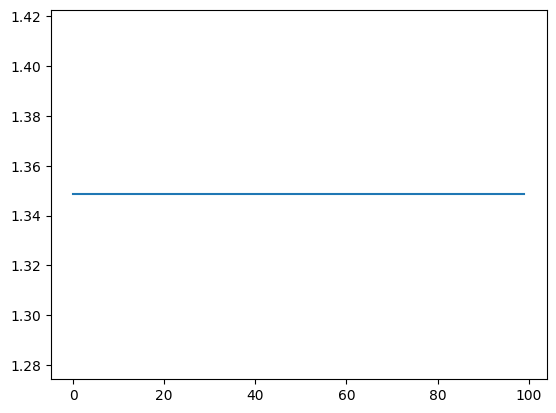

In [65]:
plt.plot(mae_out_list)

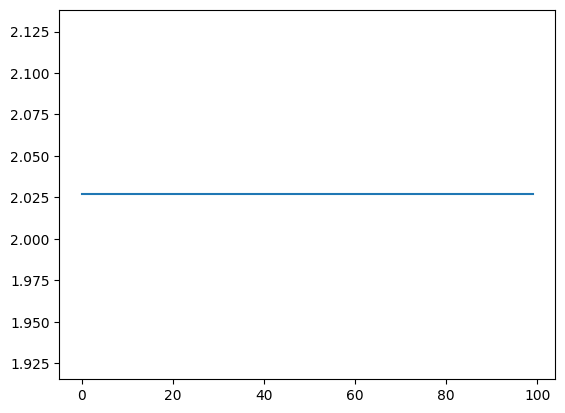

In [66]:
plt.plot(rmse_out_list)

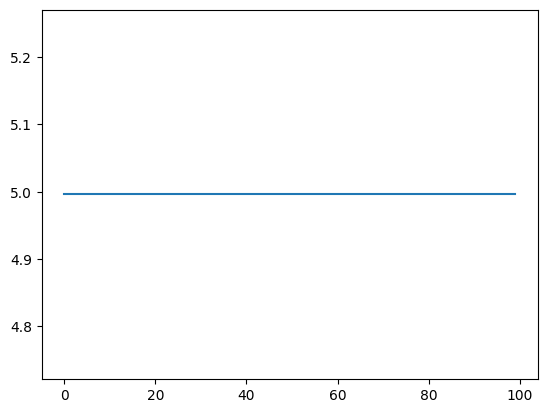

In [67]:
plt.plot(smape_out_list)